In [263]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [264]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [265]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [266]:
'''# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices) 
    #print outlier_indices
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
print train.loc[Outliers_to_drop] # Show the outliers rows
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)'''

'# Outlier detection \n\ndef detect_outliers(df,n,features):\n    """\n    Takes a dataframe df of features and returns a list of the indices\n    corresponding to the observations containing more than n outliers according\n    to the Tukey method.\n    """\n    outlier_indices = []\n    \n    # iterate over features(columns)\n    for col in features:\n        # 1st quartile (25%)\n        Q1 = np.percentile(df[col], 25)\n        # 3rd quartile (75%)\n        Q3 = np.percentile(df[col],75)\n        # Interquartile range (IQR)\n        IQR = Q3 - Q1\n        \n        # outlier step\n        outlier_step = 1.5 * IQR\n        \n        # Determine a list of indices of outliers for feature col\n        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index\n        # append the found outlier indices for col to the list of outlier indices \n        outlier_indices.extend(outlier_list_col)\n        \n    # select observations containing more than 2 outli

In [267]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [268]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [269]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [270]:
train.describe(include=['O', 'category'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [271]:
print len(train[train['Survived']==1])*1.0/len(train)
print len(train[train['Survived']==0])*1.0/len(train)

0.383838383838
0.616161616162


Survived    0    1
SibSp             
0         398  210
1          97  112
2          15   13
3          12    4
4          15    3
5           5    0
8           7    0
SibSp
0    283
1    110
2     14
3      4
4      4
5      1
8      2
Name: PassengerId, dtype: int64


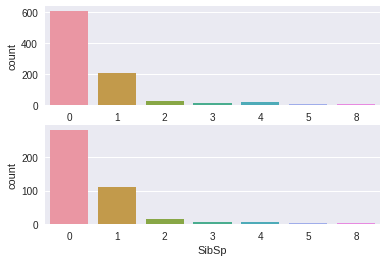

In [272]:
fig, ax = plt.subplots(2,1)
sns.countplot(x="SibSp", data=train,ax=ax[0])
sns.countplot(x="SibSp", data=test,ax=ax[1])
print pd.crosstab(train['SibSp'], train['Survived'])
print dataset[train_len:].groupby(['SibSp'])['PassengerId'].count()

In [273]:
'''0         398  210
1          97  112
2          15   13
3          12    4
4          15    3
5           5    0
8           7    0'''
print stats.binom_test(x=0,n=7,p=0.384)
print stats.binom_test(x=0,n=5,p=0.384)
print stats.binom_test(x=3,n=18,p=0.384)
print stats.binom_test(x=4,n=16,p=0.384)
print stats.binom_test(x=13,n=28,p=0.384)
print stats.binom_test(x=112,n=209,p=0.384)
print stats.binom_test(x=210,n=608,p=0.384)

0.0487123947235
0.164014597243
0.0868216054054
0.315257393201
0.438187840165
9.14089684837e-06
0.050141311888


Survived    0    1
Parch             
0         445  233
1          53   65
2          40   40
3           2    3
4           4    0
5           4    1
6           1    0
Parch
0    324
1     52
2     33
3      3
4      2
5      1
6      1
9      2
Name: PassengerId, dtype: int64


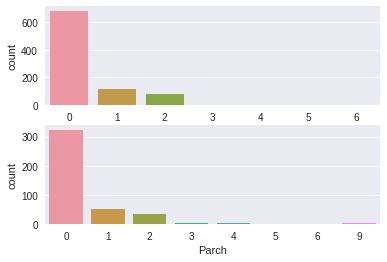

In [274]:
fig, ax = plt.subplots(2,1)
sns.countplot(x="Parch", data=train,ax=ax[0])
sns.countplot(x="Parch", data=test,ax=ax[1])
print pd.crosstab(train['Parch'], train['Survived'])
print dataset[train_len:].groupby(['Parch'])['PassengerId'].count()

In [275]:
'''Survived    0    1
Parch             
0         445  233
1          53   65
2          40   40
3           2    3
4           4    0
5           4    1
6           1    0'''
print stats.binom_test(x=0,n=1,p=0.384)
print stats.binom_test(x=1,n=5,p=0.384)
print stats.binom_test(x=0,n=4,p=0.384)
print stats.binom_test(x=3,n=5,p=0.384)
print stats.binom_test(x=40,n=80,p=0.384)
print stats.binom_test(x=65,n=118,p=0.384)
print stats.binom_test(x=233,n=678,p=0.384)

1.0
0.655329126154
0.305249456128
0.378874362757
0.0381813580553
0.000286824960761
0.0329236669056


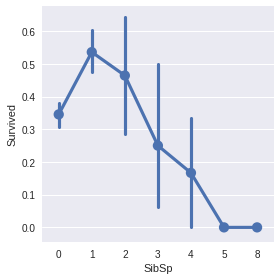

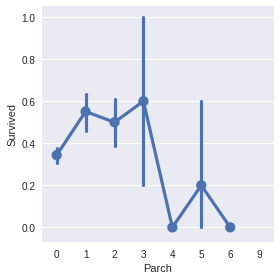

In [276]:
sns.factorplot(x="SibSp",y="Survived",data = dataset)
sns.factorplot(x="Parch",y="Survived",data = dataset)
dataset['SibSp1'] = dataset['SibSp'].map(lambda s: 1 if s == 0 else 0)
dataset['SibSp2'] = dataset['SibSp'].map(lambda s: 1 if  s == 1  else 0)
dataset['SibSp3'] = dataset['SibSp'].map(lambda s: 1 if s>=2 else 0)
dataset['Parch1'] = dataset['SibSp'].map(lambda s: 1 if s == 0 else 0)
dataset['Parch2'] = dataset['SibSp'].map(lambda s: 1 if  s == 1  else 0)
dataset['Parch3'] = dataset['SibSp'].map(lambda s: 1 if s==2 else 0)
dataset['Parch4'] = dataset['SibSp'].map(lambda s: 1 if s>=3 else 0)

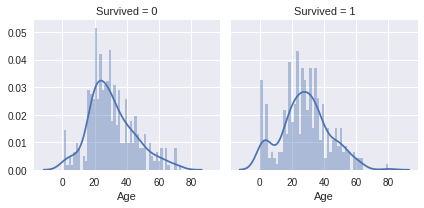

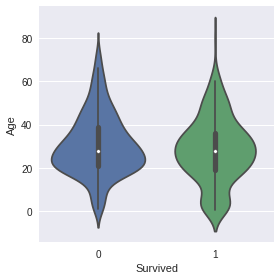

In [277]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age",bins=50)
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

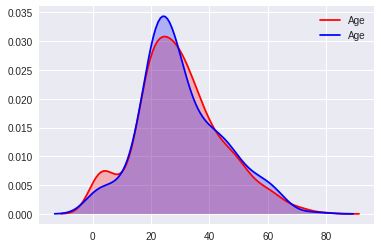

In [278]:
g = sns.kdeplot(train['Age'], color="Red", shade = True)
g = sns.kdeplot(test['Age'], ax =g, color="Blue", shade= True)

In [279]:
#train.groupby(['Age'])['PassengerId'].count()
train[train.Age<=12]['PassengerId'].count()

69

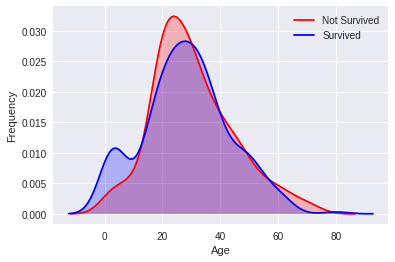

In [280]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

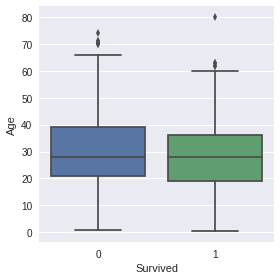

In [281]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")

In [282]:
dataset[dataset['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,SibSp1,SibSp2,SibSp3,Parch1,Parch2,Parch3,Parch4
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,1,0,0,1,0,0,0


In [283]:
median = dataset[(dataset.Pclass==3)&(dataset.Embarked=='S')]['Fare'].median()
dataset["Fare"] = dataset["Fare"].fillna(median)

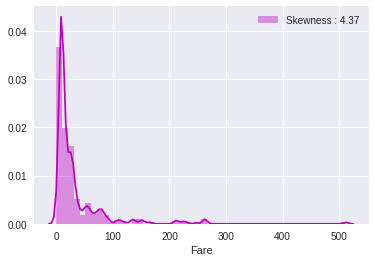

In [284]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [285]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

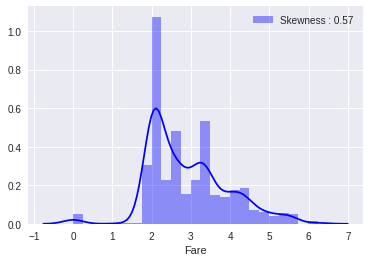

In [286]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [287]:
dataset.Fare = dataset.Fare.astype(int)


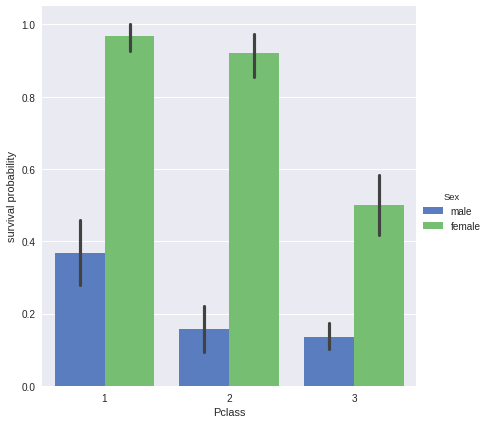

In [288]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [289]:
dataset["Pclass"] = dataset["Pclass"].astype("category")

      Age Cabin Embarked  Fare                                       Name  \
61   38.0   B28      NaN     4                        Icard, Miss. Amelie   
829  62.0   B28      NaN     4  Stone, Mrs. George Nelson (Martha Evelyn)   

     Parch  PassengerId Pclass     Sex  SibSp  Survived  Ticket  SibSp1  \
61       0           62      1  female      0       1.0  113572       1   
829      0          830      1  female      0       1.0  113572       1   

     SibSp2  SibSp3  Parch1  Parch2  Parch3  Parch4  
61        0       0       1       0       0       0  
829       0       0       1       0       0       0  


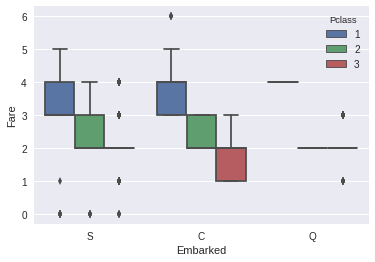

In [290]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=dataset);
print dataset[dataset['Embarked'].isnull()]
dataset["Embarked"] = dataset["Embarked"].fillna('C')

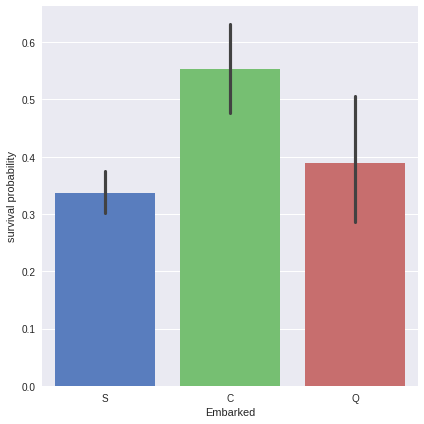

In [291]:
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Embarked
C    102
Q     46
S    270
Name: PassengerId, dtype: int64
Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64


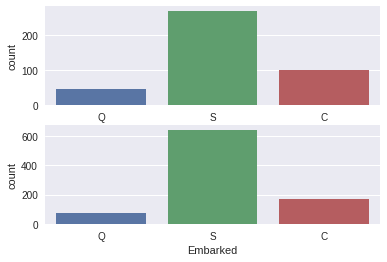

In [292]:
_,ax=plt.subplots(2,1)
sns.countplot(x="Embarked", data=test,ax=ax[0],order=['Q','S','C'])
print test.groupby(['Embarked'])['PassengerId'].count()
sns.countplot(x="Embarked", data=train,ax=ax[1],order=['Q','S','C'])
print train.groupby(['Embarked'])['PassengerId'].count()

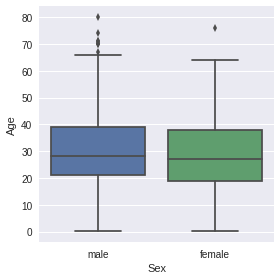

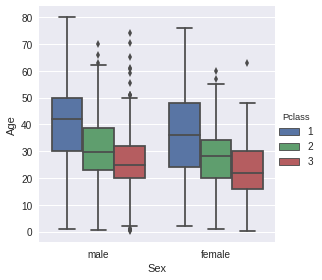

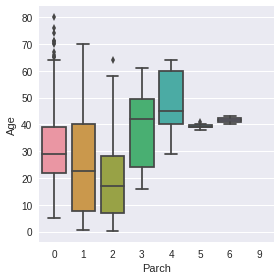

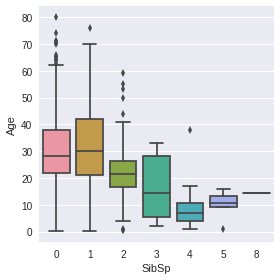

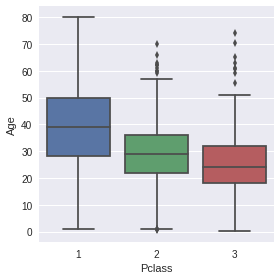

In [293]:
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
#Age distribution seems to be the same in Male and Female subpopulations, 
#so Sex is not informative to predict Age.
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Pclass", data=dataset,kind="box")

In [294]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [295]:
dataset['nullAge'] = dataset['Age'].isnull().astype(int)

In [296]:
familyPclass = dataset.groupby(['Parch','SibSp','Pclass'])['Age']
dataset['Age'] = familyPclass.transform(lambda x: x.fillna(x.mean()))
dataset['Age'] = dataset['Age'].fillna(dataset["Age"].mean())
dataset.Age = dataset.Age.astype(int)

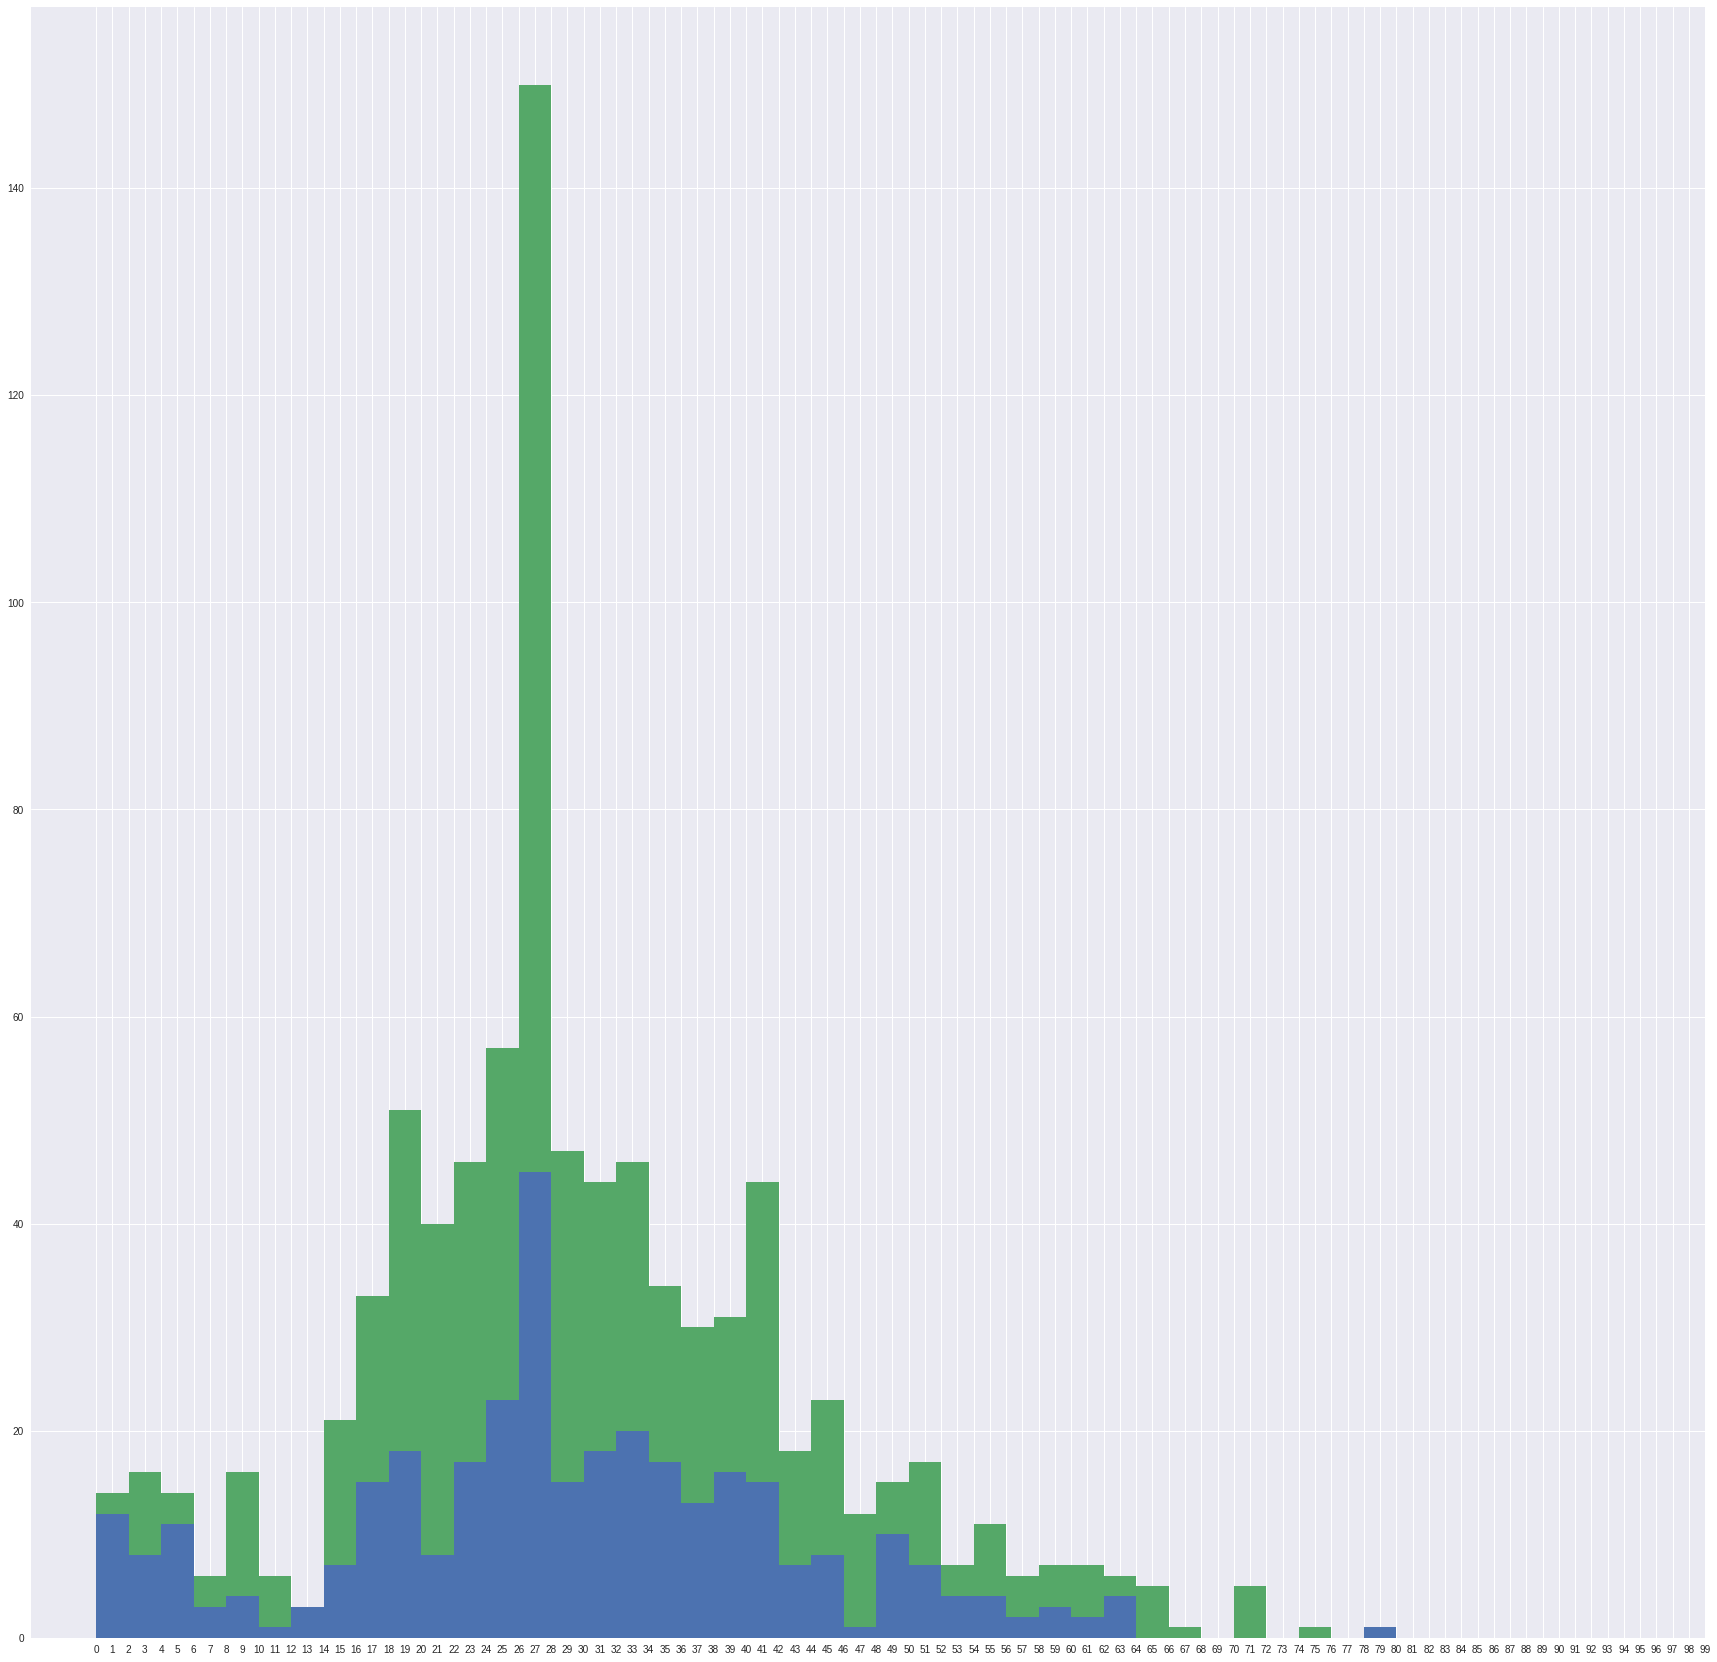

In [297]:
_,ax = plt.subplots(1,1,figsize=(30,30))
ax.hist([dataset[dataset['Survived']==1]['Age'], dataset[dataset['Survived']==0]['Age']],
         bins=40,stacked=True)
plt.xticks(range(100))
plt.show()

In [298]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [299]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [300]:
dataset['namel'] = dataset['Name'].apply(lambda x:len(x))

sqrtname
3     22
4    381
5    354
6    100
7     34
Name: Sex, dtype: int64
sqrtname
3     11
4    179
5    147
6     63
7     18
Name: Sex, dtype: int64


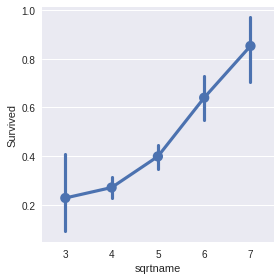

In [301]:
dataset['sqrtname'] = np.sqrt(dataset['namel'].values).astype(int)
dataset['sqrtname'] = dataset['sqrtname'].apply(lambda x:x if x !=8 and x != 9 else 7)
print dataset[:train_len].groupby(['sqrtname'])['Sex'].count()
print dataset[train_len:].groupby(['sqrtname'])['Sex'].count()
sns.factorplot(x="sqrtname",y="Survived",data = dataset)

In [302]:
dataset.drop(['namel'],axis=1,inplace=True)

Title
Capt              1
Col               2
Don               1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           40
Miss            182
Mlle              2
Mme               1
Mr              517
Mrs             125
Ms                1
Rev               6
Sir               1
the Countess      1
Name: Sex, dtype: int64
Title
Col         2
Dona        1
Dr          1
Master     21
Miss       78
Mr        240
Mrs        72
Ms          1
Rev         2
Name: Sex, dtype: int64


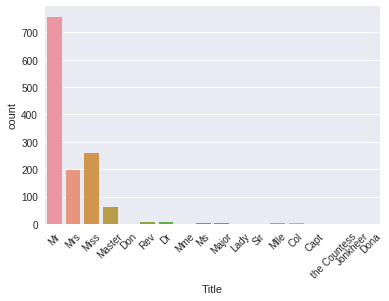

In [303]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 
print dataset[:train_len].groupby(['Title'])['Sex'].count()
print dataset[train_len:].groupby(['Title'])['Sex'].count()

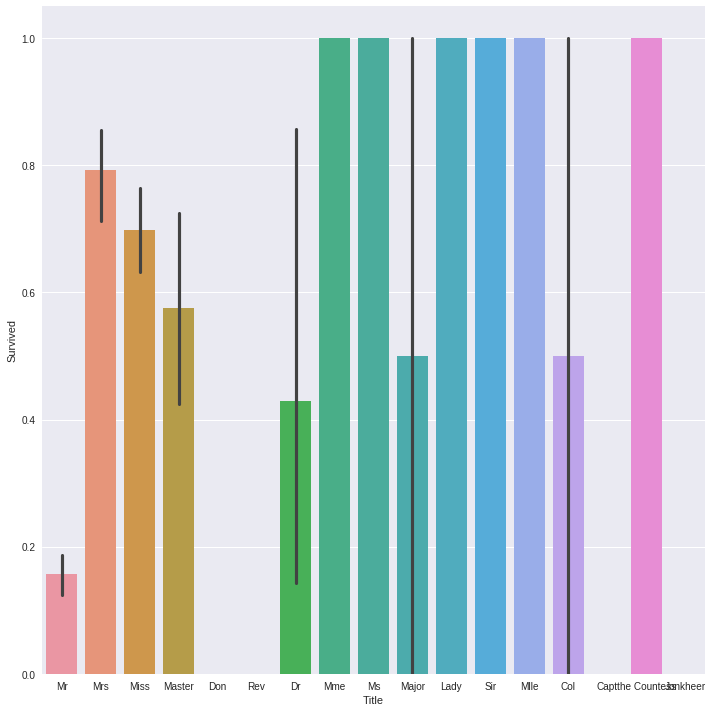

In [304]:
g = sns.factorplot(x="Title",y="Survived",data=dataset[:train_len],kind="bar",size=10)

In [305]:
# Convert to categorical values Title 
mapnew={
    "Miss":'girl',"Mlle":'del',
      'Don':'men',"Mr":'men','Sir':'del','Major':'del','Rev':'men','Dr':'men','Col':'men',
      'Jonkheer':'del','Capt':'del','the Countess':'del','Lady':'del',
      "Ms" : 'women' , 'Dona':'women',"Mme":'del', "Mrs":'women',
      'Master':'Master'
}
mapt={"Miss":'girl',"Mlle":'girl',
      'Don':'men',"Mr":'men','Sir':'men','Major':'men','Rev':'men',
      'Dr':'men','Col':'men','Jonkheer':'men','Capt':'men',
      'the Countess':'women','Dona':'women','Lady':'women',"Ms":'women',"Mme":'women',"Mrs":'women',
      'Master':'Master'
      }
dataset["Title"] = dataset["Title"].map(mapnew)

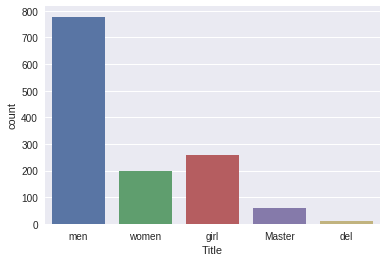

In [306]:
g = sns.countplot(dataset["Title"])

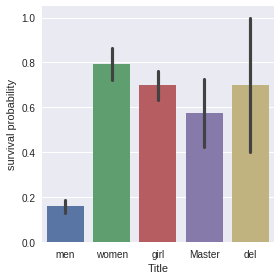

In [307]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("survival probability")

In [308]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset.drop(labels = ["Title_del"], axis = 1, inplace = True)

Fsize
1     790
2     235
3     159
4      43
5      22
6      25
7      16
8       8
11     11
Name: Name, dtype: int64

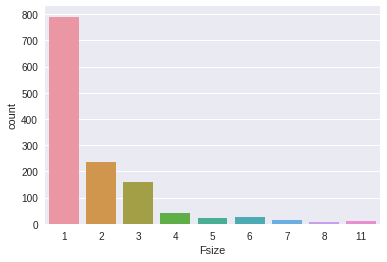

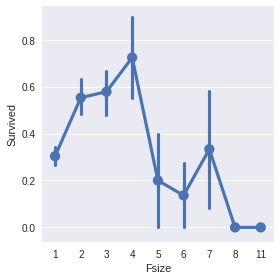

In [309]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
sns.countplot(x='Fsize',data=dataset)
sns.factorplot(x="Fsize",y="Survived",data = dataset)
g.set_ylabels("Survival Probability")
dataset.groupby(['Fsize'])['Name'].count()

In [310]:
dataset['Fsize1'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['Fsize2'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['Fsize3'] = dataset['Fsize'].map(lambda s: 1 if s==3 else 0)
dataset['Fsize4'] = dataset['Fsize'].map(lambda s: 1 if s==4  else 0)
dataset['Fsize5'] = dataset['Fsize'].map(lambda s: 1 if s>=5  else 0)

In [311]:
dataset["Cabin"].head()
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

Cabin
A     15
B     47
C     59
D     33
E     32
F     13
G      4
T      1
X    687
Name: Sex, dtype: int64
Cabin
A      7
B     18
C     35
D     13
E      9
F      8
G      1
X    327
Name: Sex, dtype: int64


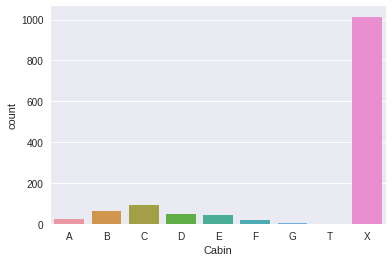

In [312]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])
print dataset[:train_len].groupby(['Cabin'])['Sex'].count()
print dataset[train_len:].groupby(['Cabin'])['Sex'].count()

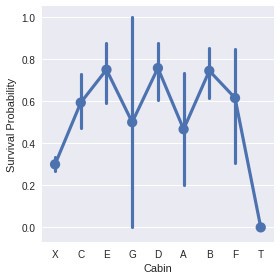

In [313]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset[:train_len])
g = g.set_ylabels("Survival Probability")

In [314]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")
dataset.drop(labels = ["Cabin_G","Cabin_T",'Cabin_F','Cabin_A'], axis = 1, inplace = True)

In [315]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [316]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [317]:
dataset["Ticket"] = pd.Series([i[0] for i in dataset['Ticket']])

Ticket
A     29
C     47
F      7
L      4
P     65
S     65
W     13
X    661
Name: Age, dtype: int64
Ticket
A     13
C     30
F      6
L      1
P     33
S     33
W      6
X    296
Name: Age, dtype: int64


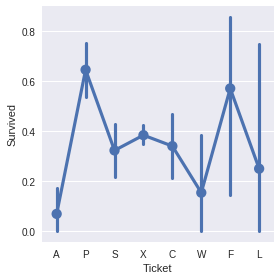

In [318]:
print dataset[:train_len].groupby(["Ticket"])['Age'].count()
print dataset[train_len:].groupby(["Ticket"])['Age'].count()
sns.factorplot(x="Ticket",y="Survived",data = dataset)

In [319]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [320]:
dataset.drop(labels = ["T_W","T_F",'T_L'], axis = 1, inplace = True)

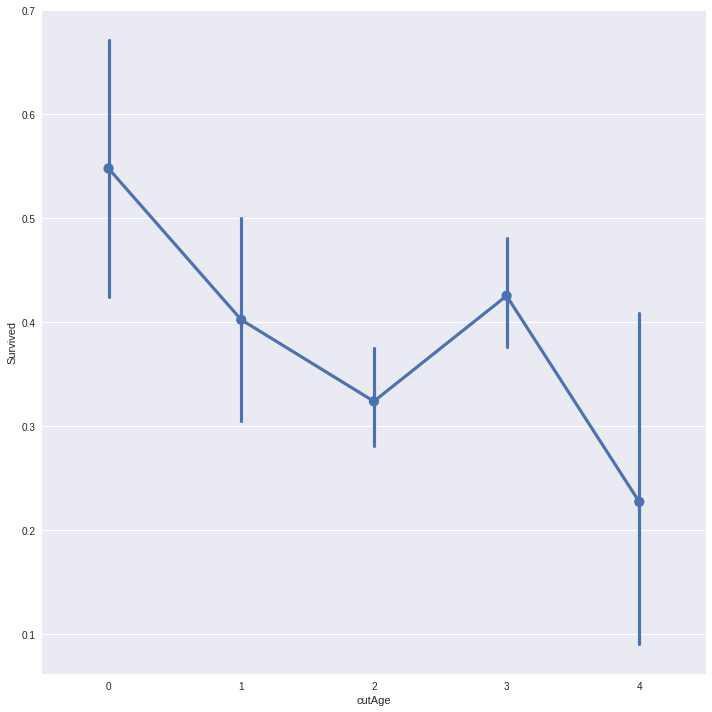

In [321]:
bins = [-0.01,12,18,30,60,100]
dataset['cutAge'] = pd.cut(dataset['Age'],bins=bins,labels=range(5))
sns.factorplot(x="cutAge",y="Survived",data = dataset,size=10)

In [322]:
print dataset[:train_len].groupby(["cutAge"])['Age'].count()
print dataset[train_len:].groupby(["cutAge"])['Age'].count()
'''(0.0902, 16.136]    109
(16.136, 32.102]    474
(32.102, 48.068]    218
(48.068, 64.034]     69
(64.034, 80.0]       11'''

cutAge
0     73
1     82
2    392
3    322
4     22
Name: Age, dtype: int64
cutAge
0     25
1     37
2    210
3    136
4     10
Name: Age, dtype: int64


'(0.0902, 16.136]    109\n(16.136, 32.102]    474\n(32.102, 48.068]    218\n(48.068, 64.034]     69\n(64.034, 80.0]       11'

In [323]:
dataset["cutAge"] = dataset["cutAge"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["cutAge"],prefix="age")

In [324]:
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [325]:
dataset.drop(labels = ["PassengerId","Name"], axis = 1, inplace = True)
dataset.drop(labels = ['SibSp','Fsize','Parch'], axis = 1, inplace = True)

In [326]:
#dataset.drop(labels = ['age_0', 'age_1', 'age_2','age_3', 'age_4'], axis = 1, inplace = True)

In [327]:
dataset.head()

,Age,Fare,Sex,Survived,SibSp1,SibSp2,SibSp3,Parch1,Parch2,Parch3,...,age_1,age_2,age_3,age_4,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3
0,22,1,0,0.0,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1
1,38,4,1,1.0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
2,26,2,1,1.0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
3,35,3,1,1.0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,1,0,0
4,35,2,0,0.0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1


In [328]:
dataset.columns.values

array(['Age', 'Fare', 'Sex', 'Survived', 'SibSp1', 'SibSp2', 'SibSp3',
       'Parch1', 'Parch2', 'Parch3', 'Parch4', 'nullAge', 'sqrtname',
       'Title_Master', 'Title_girl', 'Title_men', 'Title_women', 'Fsize1',
       'Fsize2', 'Fsize3', 'Fsize4', 'Fsize5', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_X', 'T_A', 'T_C', 'T_P', 'T_S', 'T_X',
       'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'Em_C', 'Em_Q', 'Em_S',
       'Pc_1', 'Pc_2', 'Pc_3'], dtype=object)

In [330]:
dataset = dataset[['Survived', 'Age', 'Fare', 'Sex', 'SibSp1', 'SibSp2', 'SibSp3',
       'Parch1', 'Parch2', 'Parch3', 'Parch4', 'nullAge', 'sqrtname',
       'Title_Master', 'Title_girl', 'Title_men', 'Title_women', 'Fsize1',
       'Fsize2', 'Fsize3', 'Fsize4', 'Fsize5', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_X', 'T_A', 'T_C', 'T_P', 'T_S', 'T_X',
       'age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'Em_C', 'Em_Q', 'Em_S',
       'Pc_1', 'Pc_2', 'Pc_3']]

In [331]:
dataset.to_csv('42featuresTrainNum%d.csv' % train_len)

In [332]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 43 columns):
Survived        891 non-null float64
Age             1309 non-null int64
Fare            1309 non-null int64
Sex             1309 non-null int64
SibSp1          1309 non-null int64
SibSp2          1309 non-null int64
SibSp3          1309 non-null int64
Parch1          1309 non-null int64
Parch2          1309 non-null int64
Parch3          1309 non-null int64
Parch4          1309 non-null int64
nullAge         1309 non-null int64
sqrtname        1309 non-null int64
Title_Master    1309 non-null uint8
Title_girl      1309 non-null uint8
Title_men       1309 non-null uint8
Title_women     1309 non-null uint8
Fsize1          1309 non-null int64
Fsize2          1309 non-null int64
Fsize3          1309 non-null int64
Fsize4          1309 non-null int64
Fsize5          1309 non-null int64
Cabin_B         1309 non-null uint8
Cabin_C         1309 non-null uint8
Cabin_D         1309 non-nul